    
    Análise Exploratória de Dados: Realizar uma análise exploratória dos dados disponíveis para entender a distribuição das transações, identificar padrões e detectar possíveis características distintivas das transações fraudulentas.

    Pré-processamento dos Dados: Limpar e preparar os dados para o modelo de detecção de fraudes. Isso pode envolver o tratamento de valores ausentes, normalização de atributos numéricos, codificação de variáveis categóricas e balanceamento da distribuição das classes.

    Seleção e Treinamento do Modelo: Selecionar o algoritmo de aprendizado de máquina mais adequado para o problema, como Random Forest, SVM ou redes neurais, e treinar o modelo usando os dados rotulados. O conjunto de dados rotulados consistirá em transações marcadas como legítimas ou fraudulentas com base em análises anteriores.

    Avaliação do Modelo: Avaliar o desempenho do modelo usando métricas apropriadas, como precisão, recall, F1-score e curva ROC. Também é importante considerar a detecção de falsos positivos (transações legítimas classificadas erroneamente como fraudulentas) e falsos negativos (transações fraudulentas não detectadas).

    Implantação e Monitoramento em Tempo Real: Implementar o modelo treinado em um ambiente de produção, integrando-o ao sistema de pagamentos online da empresa. Monitorar constantemente as transações em tempo real, atribuindo pontuações de risco e tomando ações adequadas com base nas decisões do modelo.
    
    Aprimoramento Contínuo: Realizar atualizações periódicas do modelo à medida que novos dados e padrões de fraude emergem. Refinar o modelo com técnicas de aprendizado contínuo e incorporar feedback dos especialistas em detecção de fraudes para melhorar a eficácia do sistema ao longo do tempo.
    
    
    
   Dataset: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

# Metadados

    passo: representa uma unidade de tempo onde 1 passo equivale a 1 hora

    tipo: tipo de transação online

    montante: o valor da transação

    nameOrig: cliente iniciando a transação

    oldbalanceOrg: saldo antes da transação

    newbalanceOrig: saldo após a transação

    nameDest: destinatário da transação

    oldbalanceDest: saldo inicial do destinatário antes da transação

    newbalanceDest: o novo saldo do destinatário após a transação

    isFraud: transação fraudulenta

# PASSO 00 IMPORTS

In [40]:
import math
import pandas as pd
import numpy  as np
import inflection
import requests
import random
import pickle
import warnings
import xgboost as xgb
import seaborn as sns


from boruta               import BorutaPy
from scipy                import stats      as ss
from matplotlib           import pyplot     as plt
from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore')

In [41]:
df_raw = pd.read_csv('../OnlineFraudDetection.csv')

In [42]:
df_raw.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [43]:
df_raw.shape

(6362620, 11)

# PASSO 01 DATA DESCRIPTION

In [44]:
df_raw.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [45]:
df_raw.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [46]:
df_raw.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [47]:
type = df_raw['type'].value_counts()
transactions = type.index
quantity = type.values


import plotly.express as px
figure = px.pie(df_raw,values=quantity,names=transactions,hole=0.5,title="Distribution Transaction Type")
figure.show()

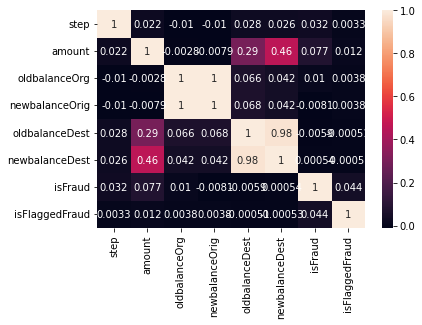

In [48]:
sns.heatmap(df_raw.corr(),annot=True);

In [49]:
correlation = df_raw.corr()
correlation

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


In [50]:
correlation['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

In [51]:
df_raw.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# PASSO 02 FEATURE ENGINEERING

# PASSO 03 Variable Filtering

# PASSO 04 Exploratory Data Analysis (EDA)

## 4.1 Univariate Analysis

## 4.2 Biavariate Analysis

## 4.2 Multivariate Analysis

# PASSO 05 Data Preparation

## 5.1 Normalization

## 5.2 Rescaling

## 5.3 Transaformation

In [52]:
df_raw.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [53]:
df_raw["type"] = df_raw["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})
df_raw["isFraud"] = df_raw["isFraud"].map({0: "No Fraud", 1: "Fraud"})

In [54]:
df_raw.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [55]:
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,No Fraud,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,No Fraud,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Fraud,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Fraud,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,No Fraud,0


# PASSO 06 Feature Selection

# PASSO 07 Machine Learning Modelling

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
df_raw.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [58]:
x = np.array(df_raw[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig']])
y = np.array(df_raw['isFraud'])

In [59]:
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest , ytrain, ytest = train_test_split(x,y,test_size=0.10,random_state=42)
model = DecisionTreeClassifier()
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.9997296711103287

In [64]:
features = np.array([[4, 500.60, 300.60, 1.0]])
print(model.predict(features))

['No Fraud']


# PASSO 08 Hyperparameter Fine tuning

# PASSO 09 Error Translate and Interpretation

# PASSO 10 Deploy Model to Production